In [41]:
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
#plt.rc('figure', facecolor='w')
from IPython.core.pylabtools import figsize
from icecream import ic
import seaborn as sns
sns.set_style('white')
%load_ext autoreload
%autoreload 2
%matplotlib inline
home_path = 'C:\\Users\joche\FIM Kernkompetenzzentrum\Projekt VIdES - Dokumente\General\\07_Arbeitsordner\\04_Ergebnisse\\20220920_Ergebnisse_4_Wochen'
os.chdir(home_path)
out_path = r'C:\Users\joche\FIM Kernkompetenzzentrum\Projekt VIdES - Dokumente\General\07_Arbeitsordner\04_Ergebnisse\20220920_Ergebnisse_4_Wochen\results\Abbildungen\v04/top_down/'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
def read_in_files(paths):
    uc_dict = {}
    paths = [paths] if type(paths) != list else paths
    for i in paths:
        uc = i.split('\\')[-1].split('use_case_')[-1].split('.xlsx')[0]
        if '_v' in uc:
           uc = uc.split('_v')[0]
        #uc = int(i.split('\\')[-1].split('use_case_')[-1][0])
        df = pd.read_excel(i, index_col=0)
        df.index = pd.to_datetime(df.index, format='%Y-%m-%dT%H:%M')
        if len(df) > 672:
            df = df.iloc[:672 - len(df),:]
        uc_dict[uc] = df
    return uc_dict

def filter_cols(df, entity):
    entity = 'grid' if 'germany' in entity and any('grid' in col for col in df.columns.tolist()) else entity
    df_out = df[[f'{entity}_grey_energy [kWh]', f'{entity}_grey_energy [%]']]
    return df_out

def insert_co2_col(df):
    # emission factors based on calculation in: https://fimrc.sharepoint.com/:x:/t/paper-VIdES/EZnJhlevmuVMi3knXpjlRuIBcDw-HWPnGKyYyXgRi7xe6g?e=7Q4Xhm
    gCO2e_kWh_green, gCO2e_kWh_grey = 0.0, 181.79
    entity = df.columns.to_list()[0].split('_')[0]
    df[f'{entity}_CO2e [t]'] = np.where(df[f'{entity}_grey_energy [kWh]'] >= 0,
                                             df[f'{entity}_grey_energy [kWh]'] * gCO2e_kWh_grey / 1e+6,
                                             df[f'{entity}_grey_energy [kWh]'] * (-1) * gCO2e_kWh_green / 1e+6)
    if 'grid' in entity:
        df.columns = [s.replace('grid', 'germany') for s in df.columns.tolist() if 'grid' in s]
    return df

In [19]:
# read in all result data frames
paths = []
for root, dir, file in os.walk(top=home_path+'/results', topdown=True):
    paths += [os.path.join(root, f) for f in file if 'kpi_3_4' in f]
# TODO: change to manually select relevant files
paths = [i for i in paths if not any(x in i for x in ['use_case_1.xlsx', 'use_case_1_v2.xlsx','use_case_2.xlsx', 'use_case_6.xlsx'])]
#paths = [i for i in paths if not 'use_case_2.xlsx' in i if not 'use_case_6.xlsx' in i if not 'use_case_1.xlsx' in i]
[i.split('\\')[-1] for i in paths]

['kpi_3_4_use_case_1_v3.xlsx',
 'kpi_3_4_use_case_0.xlsx',
 'kpi_3_4_use_case_2_v2.xlsx',
 'kpi_3_4_use_case_2-1.xlsx',
 'kpi_3_4_use_case_2-2.xlsx',
 'kpi_3_4_use_case_3.xlsx',
 'kpi_3_4_use_case_4.xlsx',
 'kpi_3_4_use_case_5.xlsx',
 'kpi_3_4_use_case_6_v2.xlsx']

In [20]:
# read in all .xslx files
uc_dict = read_in_files(paths)

In [ ]:
fig, ax = plt.subplots(figsize = (30,6), ncols=len(uc_dict.keys()), sharex=True)
for uc in range(len(uc_dict.keys())):
    uc_dict[uc][[i for i in uc_dict[uc].columns.tolist() if any(f'region-{x}_grey_energy [k' in i for x in range(1,7))]].sum(axis = 0).plot.bar(ax = ax[uc], title= f'use case {uc}: total grey energy [kWh] per region')
    ax[uc].set_xticklabels([f'region-{i}' for i in range(1,7)])
plt.tight_layout()
plt.show()

In [23]:
# for each use case: filter out relevant cols and insert co2 value
dict_out = {}
for uc in uc_dict:
    dict_out[uc] = {}
    df_ger = filter_cols(uc_dict[uc], 'germany')
    dict_out[uc]['germany'] = insert_co2_col(df_ger)
    for i in range(1,7):
        df_reg_i = filter_cols(uc_dict[uc], f'region-{i}')
        dict_out[uc][f'region-{i}'] = insert_co2_col(df_reg_i)

C:\Users\joche\AppData\Local\Temp\ipykernel_12876\3172293032.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{entity}_CO2e [t]'] = np.where(df[f'{entity}_grey_energy [kWh]'] >= 0,
C:\Users\joche\AppData\Local\Temp\ipykernel_12876\3172293032.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{entity}_CO2e [t]'] = np.where(df[f'{entity}_grey_energy [kWh]'] >= 0,
C:\Users\joche\AppData\Local\Temp\ipykernel_12876\3172293032.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy o

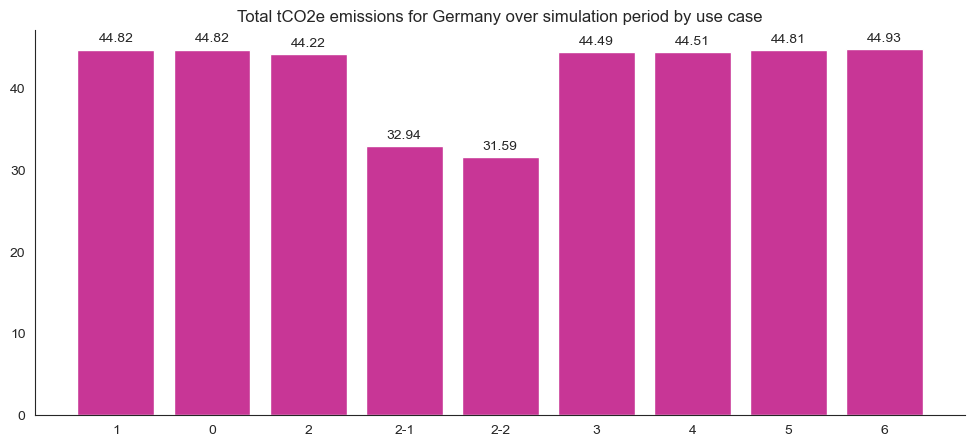

In [40]:
# total germany co2 emissions for all use cases
fig, ax = plt.subplots(figsize = (12,5), facecolor='w')
for key in dict_out:
    t = ax.bar(key, round(dict_out[key]['germany']['germany_CO2e [t]'].sum(axis=0),2), color = (184/235,50/235,138/235))
    ax.bar_label(t, padding=3)
ax.set_title('Total tCO2e emissions for Germany over simulation period by use case')
sns.despine()
plt.show()

In [42]:
fig.savefig(out_path + 'co2e_germany_all_use_cases.png')

In [49]:
# get uc0 ger values
def plot_germany_vs_uc0(dict_out, uc):
    uc0_label = f'use case 0'
    uci_label = f'use case {uc}'
    uc0_co2_ger = np.round(dict_out['0'][f'germany'][f'germany_CO2e [t]'].sum(),2)
    uci_co2_ger = np.round(dict_out[uc][f'germany'][f'germany_CO2e [t]'].sum(),2)

    fig, ax = plt.subplots(figsize = (10,5), facecolor = 'w')
    uc0 = ax.bar(uc0_label, uc0_co2_ger, color = (206/235,150/235,191/235))
    uci = ax.bar(uci_label, uci_co2_ger, color = (184/235,50/235,138/235))
    ax.set_title('Total CO2e emissions for germany over simulation period by use case')
    ax.set_ylabel('kgCO2e')
    ax.bar_label(uc0, padding=3)
    ax.bar_label(uci, padding=3)
    ax.set_ylim(0, max(uc0_co2_ger, uci_co2_ger) + 6)
    sns.despine()

    return fig

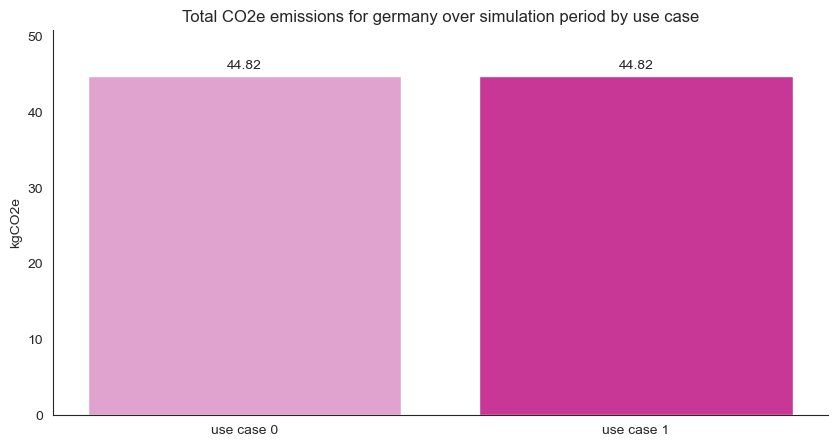

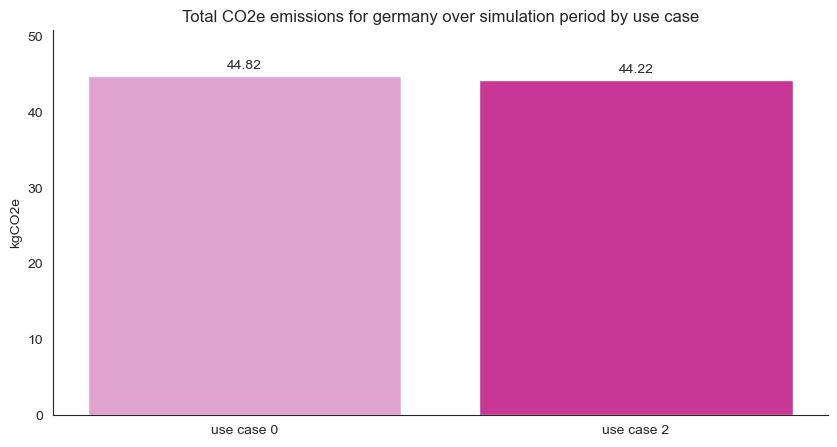

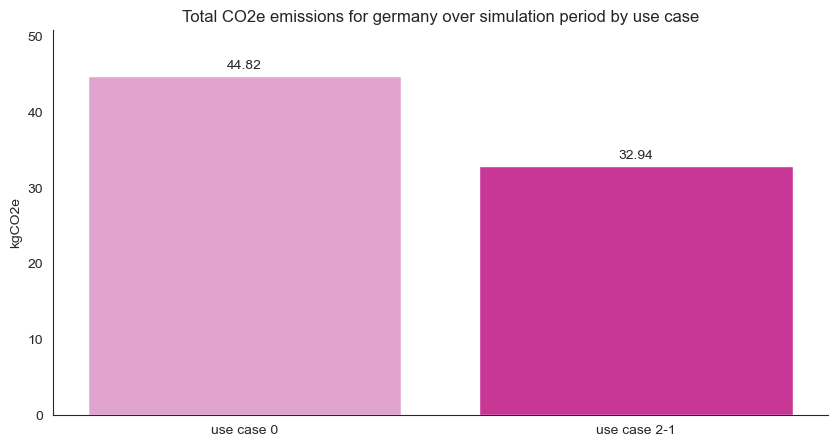

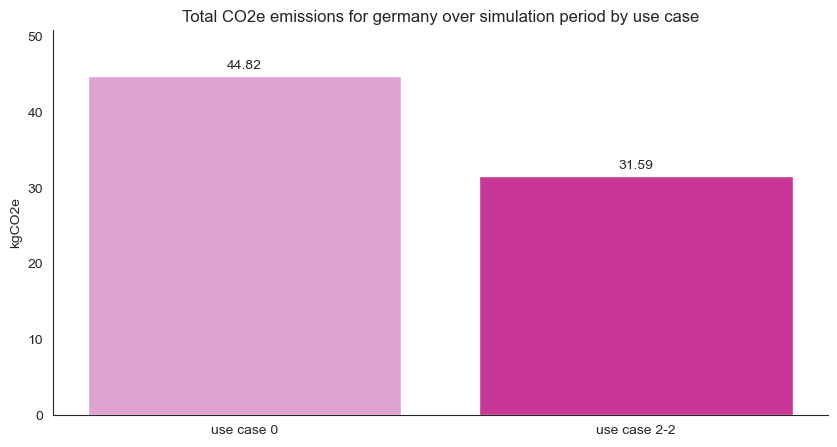

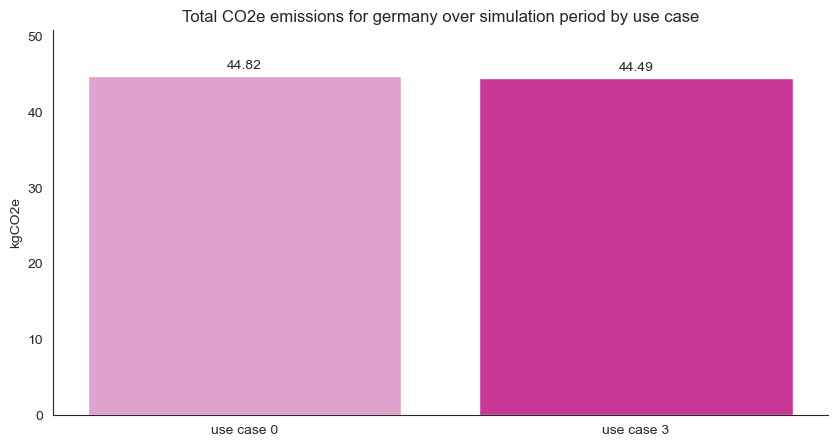

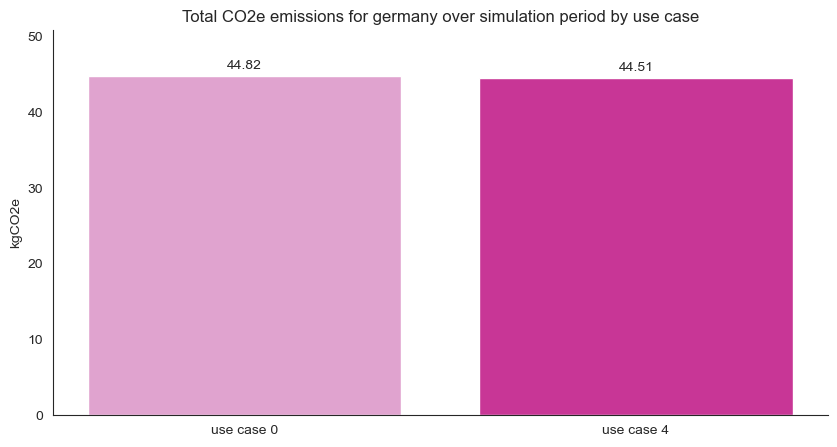

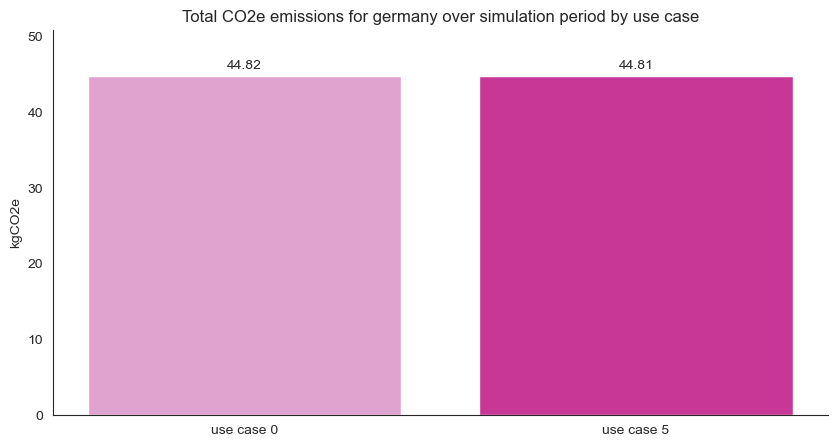

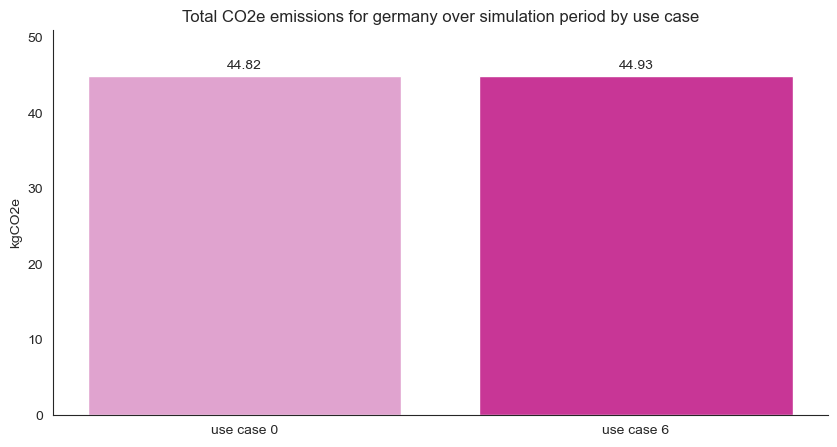

In [64]:
for key in uc_dict:
    if '0' in key:
        continue
    fig = plot_germany_vs_uc0(dict_out, uc=key)
    fig.savefig(out_path + f'co2_uc0_vs_uc{key}.png')

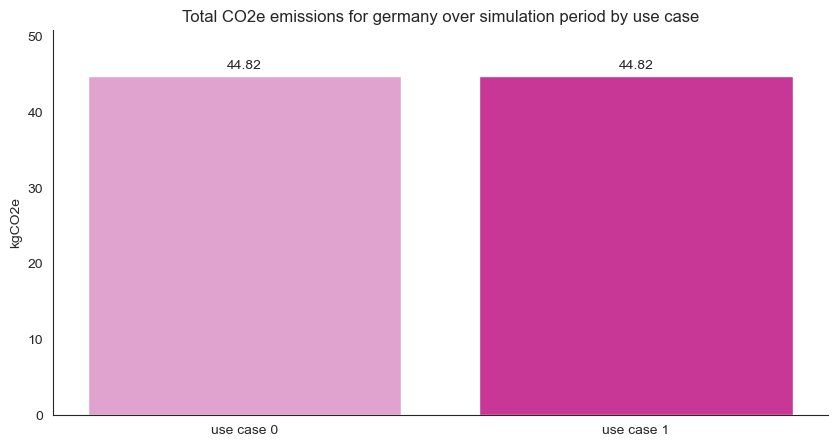

In [31]:
fig = plot_germany_vs_uc0(dict_out, uc='1')

In [58]:
def plot_regions_vs_uc0(dict_out, uc):
    labels, uc0_co2_regions, uci_co2_regions = [], [], []
    for i in range(1,7):
        labels.append(f'region-{i}')
        uc0_co2_regions.append(np.round(dict_out['0'][f'region-{i}'][f'region-{i}_CO2e [t]'].sum(),2))
        uci_co2_regions.append(np.round(dict_out[uc][f'region-{i}'][f'region-{i}_CO2e [t]'].sum(),2))
    # plot
    width = 0.4
    x = np.arange(len(labels))
    print(x)
    print(type(uc0_co2_regions), uc0_co2_regions)
    print(type(uci_co2_regions), uci_co2_regions)
    fig, ax = plt.subplots(figsize = (8,4), facecolor = 'w')
    uc0 = ax.bar(x - width/2, uc0_co2_regions, width, label = f'use case 0', color = (206/235,150/235,191/235))
    uci = ax.bar(x + width/2, uci_co2_regions, width, label = f'use case {uc}', color = (184/235,50/235,138/235))
    ax.set_title('Total CO2e emissions over simulation period by region and use case')
    ax.set_ylabel('tCO2e')
    ax.set_xticks(x, labels)
    ax.legend()
    ax.bar_label(uc0, padding=3)
    ax.bar_label(uci, padding=3)
    ax.set_ylim(0, max(max(uc0_co2_regions), max(uci_co2_regions)) + 6)
    sns.despine()

    return fig

[0 1 2 3 4 5]
<class 'list'> [2.05, 18.22, 1.39, 5.4, 11.01, 17.09]
<class 'list'> [2.05, 18.21, 1.39, 5.4, 11.02, 17.09]
[0 1 2 3 4 5]
<class 'list'> [2.05, 18.22, 1.39, 5.4, 11.01, 17.09]
<class 'list'> [2.55, 11.19, 3.04, 5.03, 5.06, 2.48]
[0 1 2 3 4 5]
<class 'list'> [2.05, 18.22, 1.39, 5.4, 11.01, 17.09]
<class 'list'> [1.45, 8.72, 2.4, 3.84, 3.55, 1.25]
[0 1 2 3 4 5]
<class 'list'> [2.05, 18.22, 1.39, 5.4, 11.01, 17.09]
<class 'list'> [1.25, 8.23, 2.26, 3.77, 3.33, 1.08]
[0 1 2 3 4 5]
<class 'list'> [2.05, 18.22, 1.39, 5.4, 11.01, 17.09]
<class 'list'> [2.02, 18.17, 1.38, 5.38, 10.94, 16.92]
[0 1 2 3 4 5]
<class 'list'> [2.05, 18.22, 1.39, 5.4, 11.01, 17.09]
<class 'list'> [2.02, 18.17, 1.38, 5.38, 10.95, 16.93]
[0 1 2 3 4 5]
<class 'list'> [2.05, 18.22, 1.39, 5.4, 11.01, 17.09]
<class 'list'> [2.05, 18.21, 1.39, 5.39, 11.02, 17.08]
[0 1 2 3 4 5]
<class 'list'> [2.05, 18.22, 1.39, 5.4, 11.01, 17.09]
<class 'list'> [3.47, 10.41, 3.18, 5.07, 5.16, 5.62]


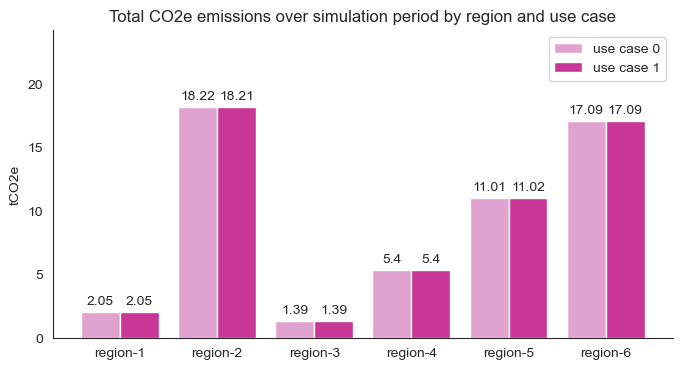

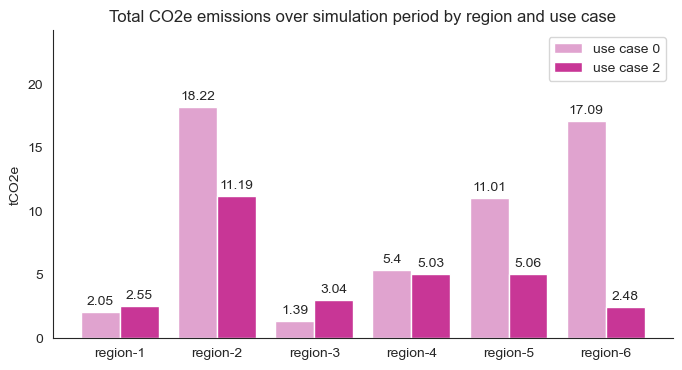

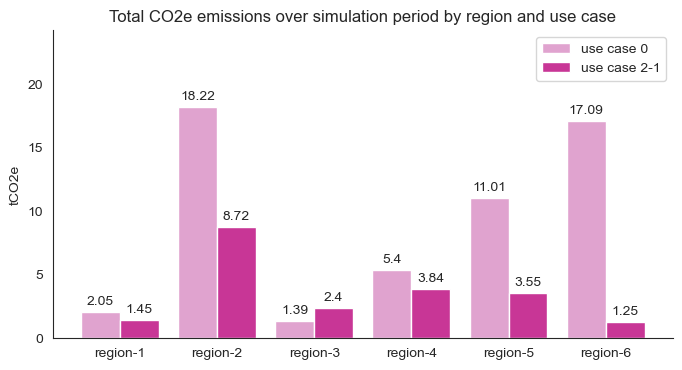

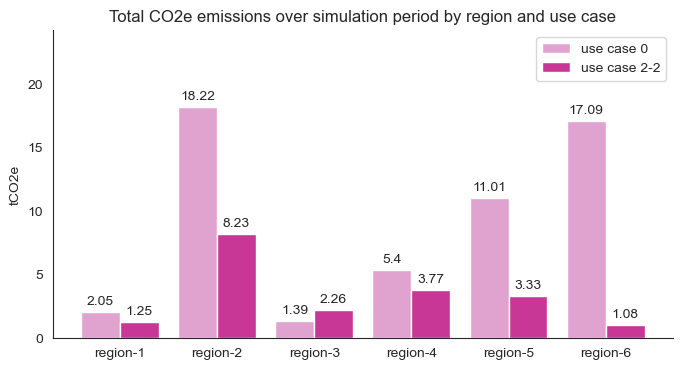

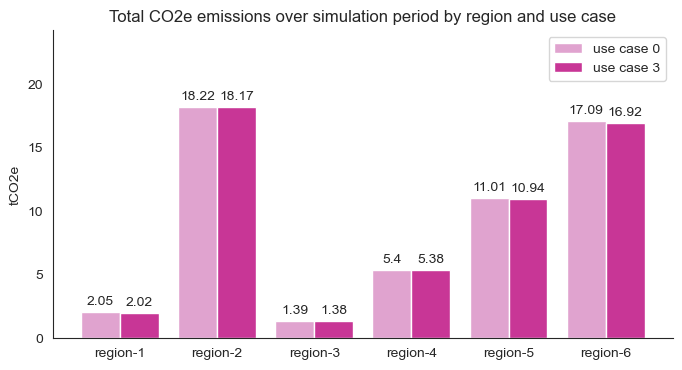

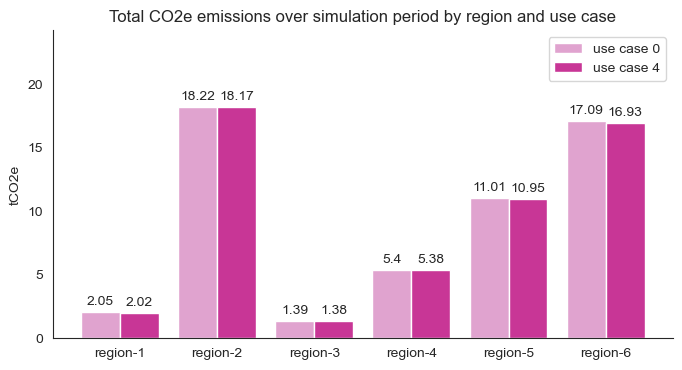

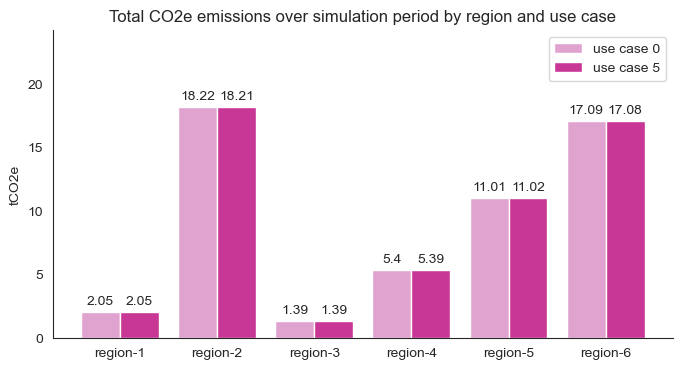

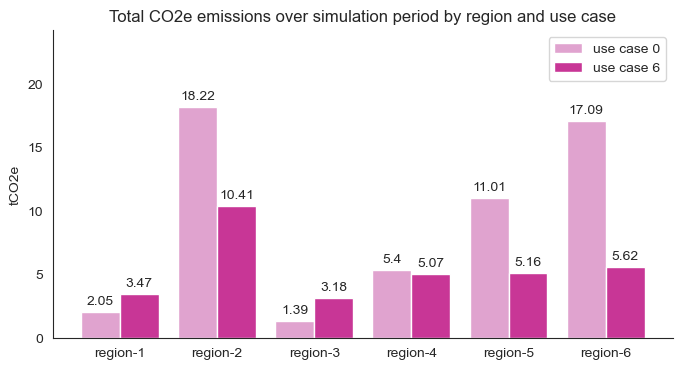

In [63]:
for key in uc_dict:
    if '0' in key:
        continue
    fig = plot_regions_vs_uc0(dict_out, uc=key)
    fig.savefig(out_path + f'co2_regions_uc0_vs_uc{key}.png')